In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [3]:
X_train_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/train/X_train.txt'
y_train_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/train/y_train.txt'
X_test_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/test/X_test.txt'
y_test_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/test/y_test.txt'

X_train = pd.read_csv(X_train_url,sep='\s+',header=None)
X_test = pd.read_csv(X_test_url,sep='\s+',header=None)
y_train = pd.read_csv(y_train_url,sep='\s+',header=None,names=['action'])
y_test = pd.read_csv(y_test_url,sep='\s+',header=None,names=['action'])
cat_url = 'https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/features.txt'
cat = pd.read_csv(cat_url,sep='\s+',header=None)

In [66]:
def get_pca_data(ss_data,n_components):
    pca = PCA(n_components=n_components)
    pca.fit(ss_data)

    return pca.fit_transform(ss_data),pca

def get_pca_ratio(pca):
    rt = pca.explained_variance_ratio_
    return np.sum(rt)

In [70]:
HAR_pca,pca = get_pca_data(X_train,n_components=3)

cols = ['PCA_'+str(i) for i in range(pca.components_.shape[0])]
df_pca = pd.DataFrame(HAR_pca,columns=cols)
df_pca['action'] = y_train


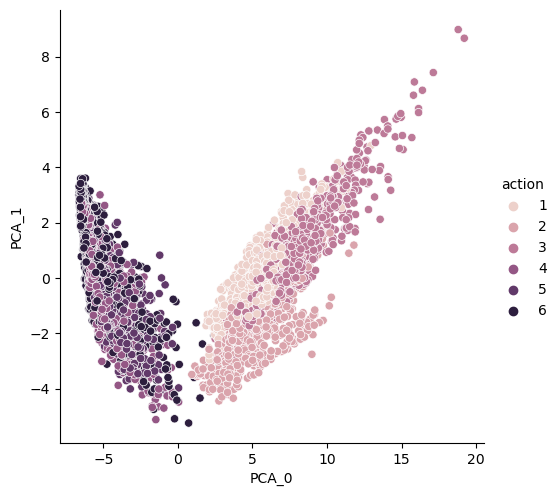

In [59]:
sns.pairplot(df_pca,x_vars=['PCA_0'],y_vars=['PCA_1'],hue='action',height=5)

In [105]:
HAR_pca, pca = get_pca_data(X_train,n_components=10)
get_pca_ratio(pca)


0.8050386797506285

In [106]:
y_train.values.reshape(-1)

array([5, 5, 5, ..., 2, 2, 2])

### PCA 주성분 축약 후 랜덤포레스트

In [107]:
params = {
    'max_depth' : [4,6,8,10],
    'n_estimators' : [30,40,50,100],
    'min_samples_leaf' : [8,12,20],
    'min_samples_split' : [8,12,20]
}
rf = RandomForestClassifier(random_state = 13, n_jobs = -1)
grid = GridSearchCV(rf, cv=2, n_jobs=-1, param_grid=params)
grid.fit(HAR_pca,y_train.values.reshape(-1))

GridSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=-1, random_state=13),
             n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [8, 12, 20],
                         'min_samples_split': [8, 12, 20],
                         'n_estimators': [30, 40, 50, 100]})

In [108]:
grid.best_estimator_
grid.best_score_
grid.cv_results_.keys()

cols = ['rank_test_score','mean_test_score','param_n_estimators','param_max_depth',]
df_rf = pd.DataFrame(grid.cv_results_)
df_rf[cols].sort_values(by='rank_test_score')

,rank_test_score,mean_test_score,param_n_estimators,param_max_depth
119,1,0.837459,100,10
83,2,0.836779,100,8
81,3,0.836507,40,8
82,4,0.836371,50,8
39,5,0.835555,100,6
...,...,...,...,...
12,139,0.817193,30,4
20,139,0.817193,30,4
27,142,0.813656,100,4
31,142,0.813656,100,4


In [120]:
%%time
rf_best = grid.best_estimator_
rf_best.fit(HAR_pca,y_train.values.reshape(-1))

pred_rf = rf_best.predict(pca.transform(X_test))
accuracy_score(y_test,pred_rf)

CPU times: user 1.9 s, sys: 262 ms, total: 2.16 s
Wall time: 586 ms


0.8588394977943672

### PCA 축약 후 XGBoost

In [131]:
y_train['action'].unique()
y_train[y_train['action']==6] = 0

In [132]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

params = {
    'learning_rate' : [0.01,0.1,0.3],
    'n_estimators' : [50,100,200],
    'max_depth' : [3,7]
}
grid_xg = GridSearchCV(xgb,param_grid=params,n_jobs=-1,cv=3)
grid_xg.fit(HAR_pca,y_train.values.reshape(-1))

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
    

In [134]:
cols = ['rank_test_score','mean_test_score','param_n_estimators','param_max_depth',]
df_xg = pd.DataFrame(grid_xg.cv_results_)
df_xg[cols].sort_values(by='rank_test_score')

,rank_test_score,mean_test_score,param_n_estimators,param_max_depth
14,1,0.848753,200,3
8,2,0.848752,200,3
13,3,0.848617,100,3
12,4,0.848480,50,3
7,5,0.845487,100,3
17,6,0.844265,200,7
11,7,0.842361,200,7
16,8,0.842088,100,7
10,9,0.841681,100,7
15,10,0.841272,50,7


In [139]:
y_test_for_xg = y_test
y_test_for_xg[y_test_for_xg['action']==6] = 0

best_xg = grid_xg.best_estimator_
best_xg.fit(HAR_pca,y_train.values.reshape(-1))
pred_2 = best_xg.predict(pca.transform(X_test))
accuracy_score(y_test_for_xg,pred_2)

0.8703766542246352

In [ ]:
evals = [(pca.transform(X_test)),y_test]